### Imports

In [1]:
import torch
import torch_geometric
import torch.nn as nn
import explainer
import networks
import datasetLoader
import evaluation
import importlib
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import networkx as nx
from typing import Literal
import torch.nn.functional as fn
from torch_geometric.utils import k_hop_subgraph
import utils
from torch_geometric.utils import to_undirected

importlib.reload(datasetLoader)
importlib.reload(networks)
importlib.reload(explainer)
importlib.reload(utils)
importlib.reload(evaluation)

<module 'evaluation' from 'c:\\Users\\trist\\Git_repos\\BT-ML-PGESAT\\code\\PGExplainer\\evaluation.py'>

### Parameters Explainer

In [2]:
batch_size = 1
sampled_graphs = 20

learning_rate_mlp = 0.003       #Paper: 0.003,
coefficientSizeReg = 0.0001       #Paper: 0.05, code 0, codePyG 0.01
entropyReg = 0.01               #Paper: 1, code 0, codePyG 10.0
epochs_mlp = 20                 #Paper: 30 for all datasets => 20 enough for BA2Motif
# TODO: Budget, connectivity

# Temperature
t_0 =  5.0
t_T = 1.0                       #Paper says 2.0, Code seems to use 1.0 => 1.0 seems to work good

datasetName: Literal['BA-Shapes', 'BA-Community', 'Tree-Cycles', 'Tree-Grid'] = 'Tree-Cycles'

## Visualize Data TODO: NodePlot function

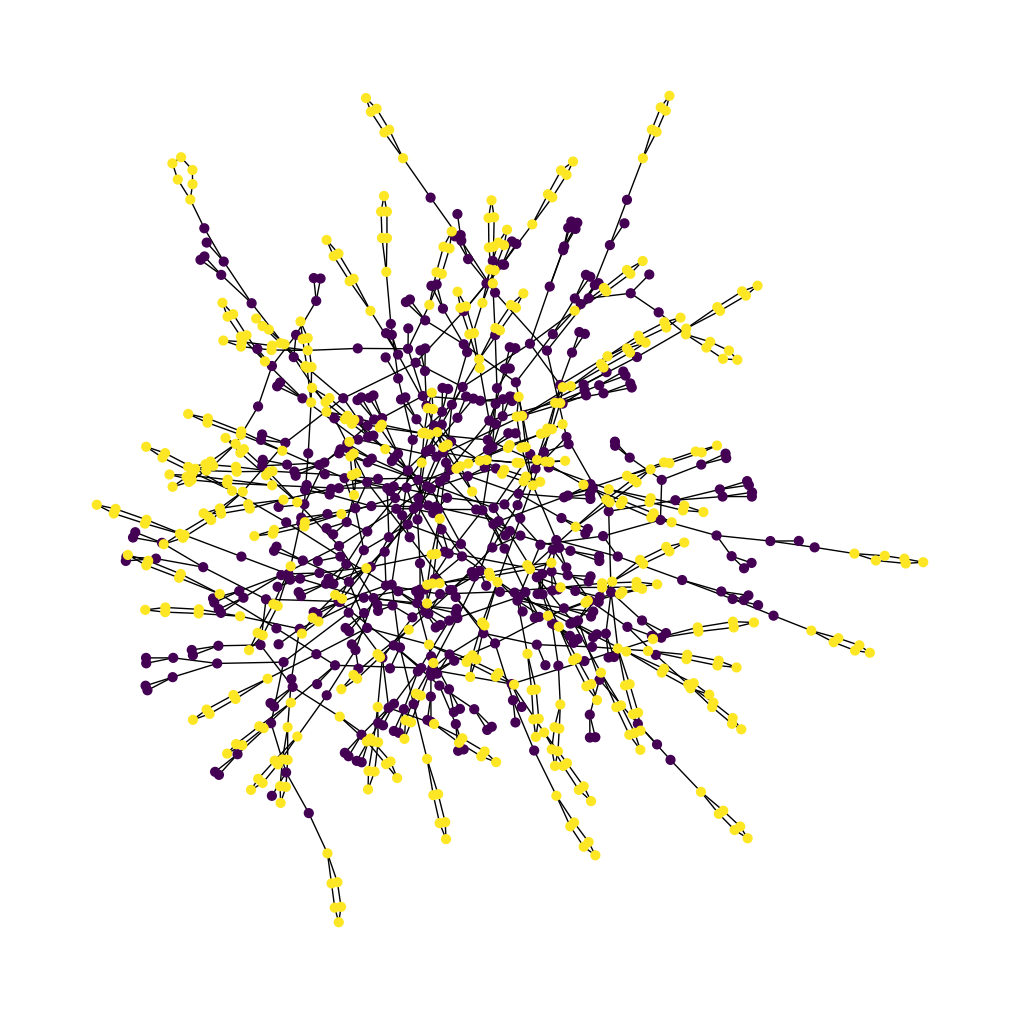

In [3]:
labels, data = datasetLoader.loadNodeDataset(datasetName)

colors = []

for i, j in enumerate(data.y):
    colors.append([j.item()])

g = torch_geometric.utils.to_networkx(data, to_undirected=True)

pos = nx.spring_layout(g, seed=42)          # try kamada_kawai_layout
plt.figure(figsize=(10, 10))  # You can adjust the size as needed

nx.draw(g, pos, node_size=40,font_size=8, node_color = colors)

#trainLoader = DataLoader(data, 1, True)

### Load GNN model

In [4]:
modelNodeGNN = networks.NodeGNN(features = data.x.shape[1], labels=labels)     # Adjust according to data and task
modelNodeGNN.load_state_dict(torch.load("models/TreeCycles 100", weights_only=True))

<All keys matched successfully>

## RandomAUCNode for evaluation during training. CHANGE

In [7]:
a = (data.y == 1).nonzero()
randomAUCNode = torch.randint(a[0], a[len(a)-1]+1, [1,1]).item()

print(randomAUCNode)

685


In [5]:
edge_index_undirected = to_undirected(data.edge_index)

### Training Loop Graph Classification Explainer

In [ ]:
#torch.set_printoptions(threshold=10_000)
mlp = explainer.MLP(GraphTask=False)

mlp_optimizer = torch.optim.Adam(params = mlp.parameters(), lr = learning_rate_mlp, maximize=False)

modelNodeGNN.eval()
for param in modelNodeGNN.parameters():
    param.requires_grad = False

# TODO: Move this to data loader / preparation
#edge_index_undirected = to_undirected(data.edge_index)

for epoch in range(0, epochs_mlp) :
    mlp.train()
    mlp_optimizer.zero_grad()

    temperature = t_0*((t_T/t_0) ** ((epoch+1)/epochs_mlp))
    temperature = 5.0

    Loss = torch.FloatTensor([0])

    # Iterate over NODES in data
    for node_index, nodeFeatures in enumerate(data.x):
        #Calculate k-hop graph for node
        subset, edge_index_hop, mapping, edge_mask = k_hop_subgraph(node_idx=node_index, num_hops=3, edge_index=edge_index_undirected, relabel_nodes=True)
        
        # Get index for node to predict in subset, since edge_index is relabeled to match features
        indexNodeToPred = (subset == node_index).nonzero().item()
        
        # MLP forward                                                           # shape embeddings[batch_index]: ~50 X 60 = Edges X hidden_embs_3Nodes
        w_ij = mlp.forward(modelGraphGNN=modelNodeGNN, x=data.x[subset], edge_index=edge_index_hop, nodeToPred=indexNodeToPred)               # shape: ~50 X 1 = Edges X MLP_out(edge_weight)

        sampleLoss = Loss = torch.FloatTensor([0])
        
        for k in range(0, sampled_graphs):
            # Sample with reparam trick via edge weights
            edge_ij = mlp.sampleGraph(w_ij, temperature)

            # TODO: This softmax is needed for the prediction of the downstream task and should probably be moved into the GNN model!!!
            # until then it is def needed here. Probably correct here, can also be found in og Explainer.call
            # TODO: Hpw do I calc loss? Between k-hop graph and original graph not possible. Only take node_idx from original and sampled?
            pOriginal = fn.softmax(modelNodeGNN.forward(data.x[subset], edge_index_hop), dim=1)
            pSample = fn.softmax(modelNodeGNN.forward(data.x[subset], edge_index_hop, edge_weights=edge_ij), dim=1)

            # TODO: Validate loss function, True_one_hot labels needed??
            # TODO: Implement correct loss for each graph per batch => Should be good
            #for graph_index in range(data.num_graphs):
            #    node_mask = data.batch == graph_index
            #    edge_mask = (node_mask[data.edge_index[0]] & node_mask[data.edge_index[1]])

            # TODO: VALIDATE pOriginal and pSample pass both label predictions, not just correct one
            #print(f"pOriginal[node_index] {node_index} {pOriginal[node_index]}")
            #print(f"pSample[indexNodeToPred] {pSample[indexNodeToPred]}")
            currLoss = mlp.loss(pOriginal[indexNodeToPred], pSample[indexNodeToPred], edge_ij, coefficientSizeReg, entropyReg, 1e-4)
            sampleLoss += currLoss
        
        Loss += sampleLoss / sampled_graphs
        
    Loss.backward()
    
    #Loss = Loss / len(train_loader.dataset)

    print(f"Epoch {epoch+1}, Loss: {Loss.item()}")

    torch.nn.utils.clip_grad_norm_(mlp.parameters(), max_norm=2)           # clip value imn -2

    mlp_optimizer.step()

    mlp.eval()
    

    evaluation.evaluateNodeExplainerAUC(mlp, modelNodeGNN, data, edge_index_undirected, randomAUCNode)
    #out = mlp.forward(modelNodeGNN, data.x, data.edge_index)

    #print(f"MLP Output for first val graph in epoch {epoch+1}:")
    #print(out.squeeze(1))

    """for name, param in mlp.named_parameters():
        if param.requires_grad:
            print(f"{name}: {param.grad}")"""

Epoch 1, Loss: 0.16917358338832855
AUC of ROC: 0.0
BinaryAUROC: 0.0
roc_auc_score: 0.0
Epoch 2, Loss: 0.16453146934509277
AUC of ROC: 0.0
BinaryAUROC: 0.0
roc_auc_score: 0.0
Epoch 3, Loss: 0.15738363564014435
AUC of ROC: 0.3333333432674408
BinaryAUROC: 0.3333333333333333
roc_auc_score: 0.3333333333333333
Epoch 4, Loss: 0.14358046650886536
AUC of ROC: 0.3333333432674408
BinaryAUROC: 0.3333333333333333
roc_auc_score: 0.3333333333333333
Epoch 5, Loss: 0.1320132315158844
AUC of ROC: 0.3333333432674408
BinaryAUROC: 0.3333333333333333
roc_auc_score: 0.3333333333333333
Epoch 6, Loss: 0.11797283589839935
AUC of ROC: 0.3333333432674408
BinaryAUROC: 0.3333333333333333
roc_auc_score: 0.3333333333333333
Epoch 7, Loss: 0.10455548763275146
AUC of ROC: 0.3333333432674408
BinaryAUROC: 0.3333333333333333
roc_auc_score: 0.3333333333333333
Epoch 8, Loss: 0.09354923665523529
AUC of ROC: 0.3333333432674408
BinaryAUROC: 0.3333333333333333
roc_auc_score: 0.3333333333333333
Epoch 9, Loss: 0.08366550505161285


### TODO: Evaluate AUC for "start node" of each motif: [i for i in range(511,871,6)]

### PROBLEM: Mask predicts 1 for each node, not only motif nodes! Stop weights from growing that huge, grad clipping?

AUC not computable
tensor([42.0279, 42.0279, 42.0279, 42.0279, 47.0513, 42.0279, 42.0279, 26.0436,
        33.4142, 26.0436, 25.4821, 25.4821, 25.4821, 25.4821, 26.0436, 26.0436,
        33.4142, 47.0513, 33.4142, 33.4142], grad_fn=<CopySlices>)
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.], grad_fn=<SigmoidBackward0>)


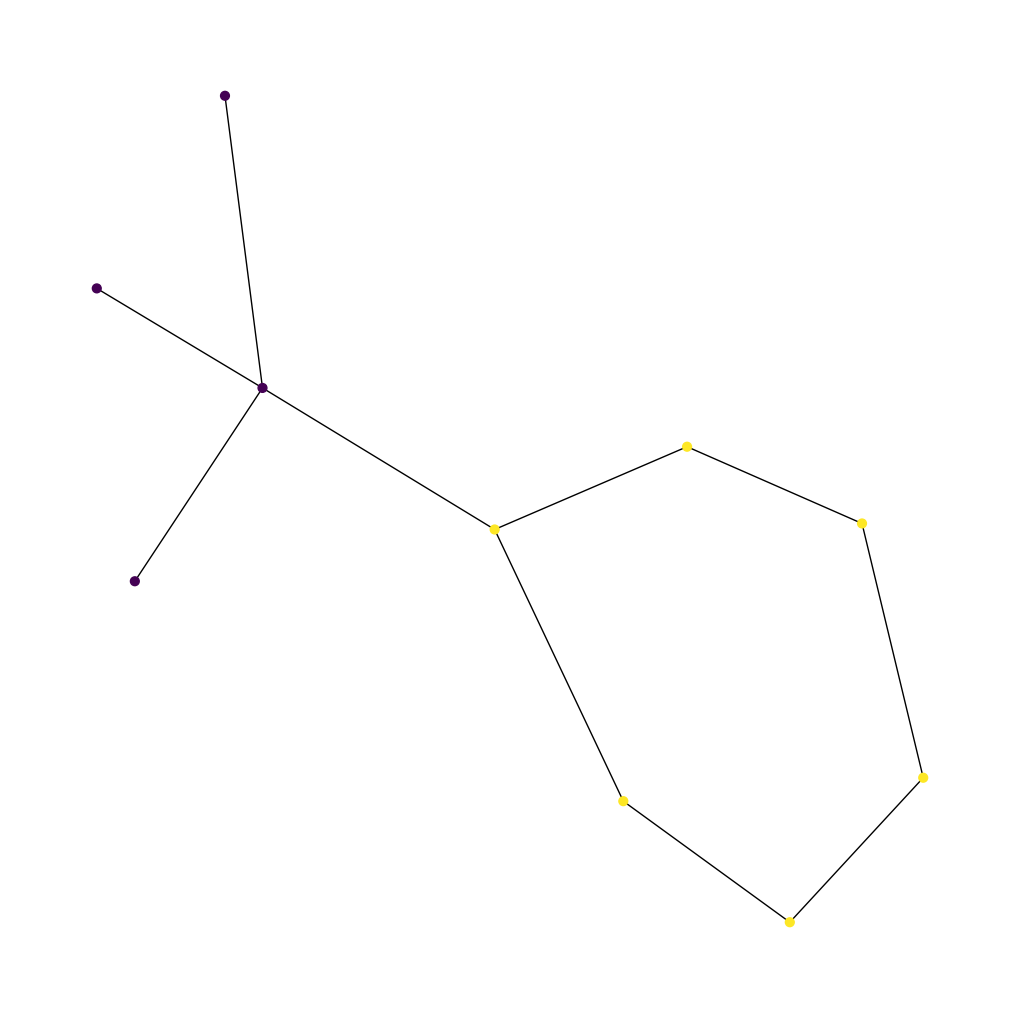

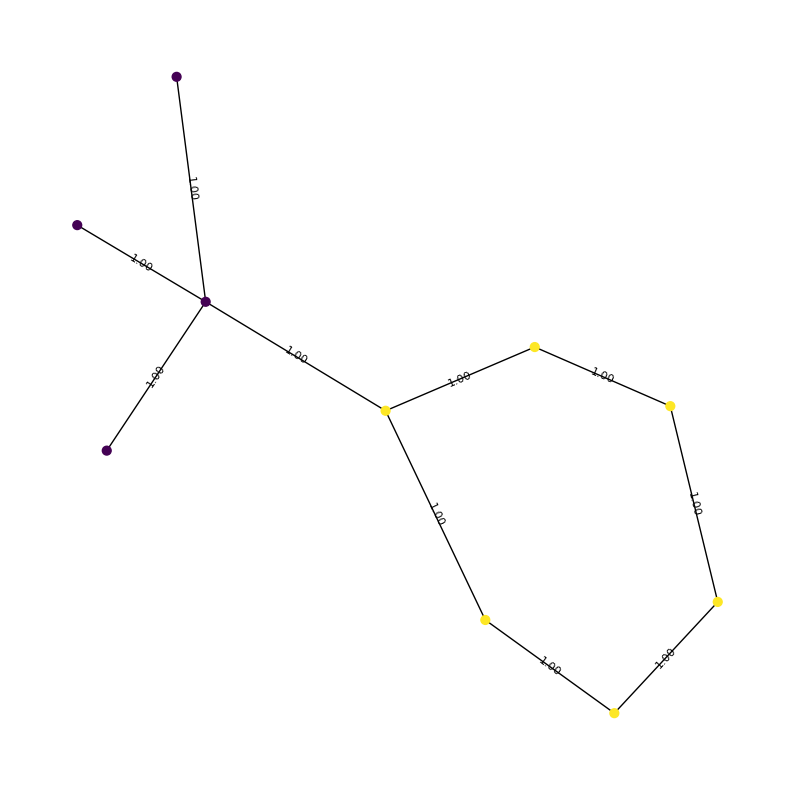

In [15]:
mlp.eval()
modelNodeGNN.eval()

AUCNode = [i for i in range(511,871,6)]
currentAUC = AUCNode[1]

dataA = evaluation.evaluateNodeExplainerAUC(mlp, modelNodeGNN, data, edge_index_undirected, currentAUC)

subset, edge_index_hop, mapping, edge_mask = k_hop_subgraph(node_idx=currentAUC, num_hops=3, edge_index=edge_index_undirected, relabel_nodes=True)

indexNodeToPred = (subset == currentAUC).nonzero().item()

colors = []

G_hop = Data(x=data.x[subset], edge_index=edge_index_hop, y=data.y[subset])
g = torch_geometric.utils.to_networkx(G_hop, to_undirected=True)

for i, j in enumerate(G_hop.y):
    colors.append([j.item()])

pos = nx.spring_layout(g, seed=42)          # try kamada_kawai_layout
plt.figure(1, figsize=(10, 10))

nx.draw(g, pos, node_size=40,font_size=8, node_color = colors)





w_ij = mlp.forward(modelNodeGNN, data.x[subset], edge_index_hop, indexNodeToPred)
print(w_ij)
edge_ij = mlp.sampleGraph(w_ij, temperature)
print(edge_ij)

plt.figure(2, figsize=(10, 10))

GraphSampled = Data(x=G_hop.x,edge_index=G_hop.edge_index,edge_attr=edge_ij.detach())
g2 = torch_geometric.utils.to_networkx(GraphSampled, edge_attrs=["edge_attr"], to_undirected="upper")

labels = nx.get_edge_attributes(g2,'edge_attr')
labels = {edge: f"{weight:.2f}" for edge, weight in nx.get_edge_attributes(g2, 'edge_attr').items()}
nx.draw_networkx_edge_labels(g2, pos, edge_labels=labels, font_size=8)
        
nx.draw(g2, pos, node_size=40,font_size=8, node_color = colors)

plt.show()